# Exercise 6
*CS-E5885 Modeling Biological Networks* <br>
*16th Feb, 2021* <br>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gammaln
import matplotlib

## 0. Data

We start with the same artificial data as in Exercise 5, with time-course measurements of the expression of three genes $X_1$, $X_2$, $X_3$.

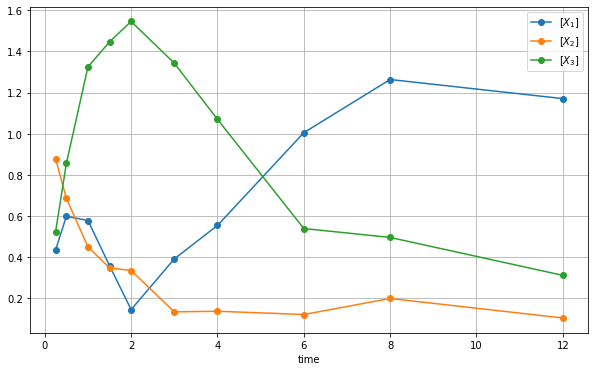

In [2]:
t_data = np.array([0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8, 12]) # time points
Y_data = np.array([
    [0.43363251, 0.87767177, 0.52257947],
    [0.59829549, 0.68515400, 0.85511583],
    [0.57771761, 0.44965359, 1.32524242],
    [0.35806804, 0.34666734, 1.44662417],
    [0.14424849, 0.33451828, 1.54588553],
    [0.39095813, 0.13332767, 1.34309046],
    [0.55361681, 0.13633700, 1.07001529],
    [1.00481754, 0.12037373, 0.53871530],
    [1.26352803, 0.19847235, 0.49535966],
    [1.17064081, 0.10360132, 0.31091261]])

plt.figure(figsize=(10,6))
plt.plot(t_data, Y_data, marker = "o")
plt.grid()
plt.legend(('$[X_1]$', '$[X_2]$', '$[X_3]$'))
plt.xlabel('time')
plt.show()

Our goal is to compare different Bayesian network models $G$ by comparing their posterior probabilities 

\begin{equation}
p(G \mid \mathcal{D}) \propto p(\mathcal{D} \mid G) p(G)
\end{equation}

We will consider only models that can be represented by a directed acyclic graph (DAG), where each node (gene) can have at most one parent node.

## 1. Discretizing and summarizing the data (1.5 p)

**a)** You need to first discretize the data. Create a data matrix `Y_disc` (a numpy array with same shape as `Y_data`)  which has only values 1, 2 and 3 so that

* 1 = under-expression
* 2 = normal expression
* 3 = over-expression

Do this so that for each gene separately, expression values 

* smaller than or equal to the first quartile are considered under-expression (value 1)
* between first and third quartiles are considered normal expression (value 2)
* larger than or equal to the third quartile are considered over-expression (value 3)

(Hint: [`np.quantile`](https://numpy.org/doc/stable/reference/generated/numpy.quantile.html))

In [3]:
Y_disc = np.copy(Y_data)
for i in range(3):
    under = np.quantile(Y_data[:,i], 0.25)
    normal = np.quantile(Y_data[:,i], 0.5)
    over = np.quantile(Y_data[:,i], 0.75)
    for j in range(len(Y_data[:,i])):
        if Y_data[j,i] <= under:
            Y_disc[j,i] = 1
        elif Y_data[j,i] > under and Y_data[j,i] < over:
            Y_disc[j,i] = 2
        elif Y_data[j,i] >= over:
            Y_disc[j,i] = 3
print(Y_disc)

[[2. 3. 1.]
 [2. 3. 2.]
 [2. 3. 2.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 1. 3.]
 [2. 2. 2.]
 [3. 1. 2.]
 [3. 2. 1.]
 [3. 1. 1.]]


**b)** Run the below code that visualizes the discretized data.

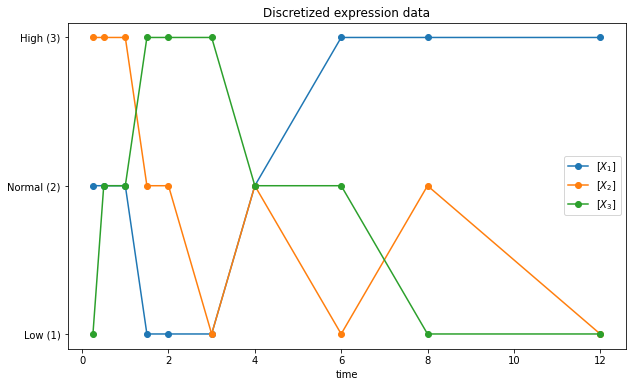

In [4]:
plt.figure(figsize=(10,6))
plt.plot(t_data, Y_disc, marker = "o")
plt.legend(('$[X_1]$', '$[X_2]$', '$[X_3]$'))
plt.xlabel('time')
plt.yticks([1,2,3])
plt.yticks([1,2,3], ['Low (1)', 'Normal (2)', 'High (3)'])
plt.title("Discretized expression data")
plt.show()

**c)** Complete the below functions that computes state and state pair frequencies.

In [5]:
def frequencies(y):
    """Compute observed state frequencies of one gene.
        
    :param y: a 1-D numpy array containing observations of one gene
    :returns: A 1-D numpy array freqs, which has shape (3,) and
       - freqs[0] = #obs. where the gene is under-expressed
       - freqs[1] = #obs. where the gene is normally expressed
       - freqs[2] = #obs. where the gene is over-expressed
    """
    freqs = [0]*3
    for i in range(len(y)):
        idx = int(y[i])
        freqs[idx-1] +=1
    return freqs # todo

In [6]:
def frequencies_pair(y, y_parent):
    """Compute observed state pair frequencies of a gene and its parent.
        
    :param y: a 1-D numpy array containing observations of a gene
    :param y_parent: a 1-D numpy array containing observations of its parent
    :returns: A 2-D numpy array freqs, which has shape (3,3) and
       - freqs[0,0] = #obs. where gene is under-expressed and its parent is under-expressed
       - freqs[0,1] = #obs. where gene is under-expressed and its parent is normally expressed
       - freqs[0,2] = #obs. where gene is under-expressed and its parent is over-expressed
       - freqs[1,0] = #obs. where gene is normally expressed and its parent is under-expressed
       - freqs[1,1] = #obs. where gene is normally expressed and its parent is normally expressed
       - freqs[1,2] = #obs. where gene is normally expressed and its parent is over-expressed
       - freqs[2,0] = #obs. where gene is over-expressed and its parent is under-expressed
       - freqs[2,1] = #obs. where gene is over-expressed and its parent is normally expressed
       - freqs[2,2] = #obs. where gene is over-expressed and its parent is over-expressed
    """
    freqs = np.zeros((3, 3))
    for i in range(len(y)):
        index = int(y[i]) - 1
        parent_index = int(y_parent[i]) - 1
        freqs[index][parent_index] +=1
    return freqs # todo

**d)** Test your functions by running the following cells.

In [7]:
N_1 = frequencies(Y_disc[:,0])
N_2 = frequencies(Y_disc[:,1])
N_3 = frequencies(Y_disc[:,2])
print("X1 frequencies: " + str(N_1))
print("X2 frequencies: " + str(N_2))
print("X3 frequencies: " + str(N_3))

X1 frequencies: [3, 4, 3]
X2 frequencies: [3, 4, 3]
X3 frequencies: [3, 4, 3]


In [8]:
N_13 = frequencies_pair(Y_disc[:,0], Y_disc[:,2])
print("Frequency table when gene = X1 and parent = X3:\n\n", N_13)

Frequency table when gene = X1 and parent = X3:

 [[0. 0. 3.]
 [1. 3. 0.]
 [2. 1. 0.]]


## 2. Network scoring (2 p)

Read Lecture 9. We consider Bayesian networks with a Dirichlet parameter prior that factorizes over nodes and parent configurations. The marginal likelihood of the data $\mathcal{D}$, given network structure $G$, has the form

$$
p(\mathcal{D} \mid G) = \prod_{i=1}^{3} \text{score}_i(G),
$$

where $\text{score}_i(G)$ is the score for node $i$. As seen in the lecture, the score is

$$
\text{score}_i(G) = \prod_{j=1}^{R_i} \left[ \frac{\Gamma(\alpha_{ij})}{\Gamma(\alpha_{ij} + N_{ij})} \prod_{k=1}^3 \frac{\Gamma(\alpha_{ijk} + N_{ijk})}{\Gamma(\alpha_{ijk})} \right],
$$

where 

* $R_i$ is the number of possible states for the parent of gene $i$
* If gene $i$ has no parent, then $R_i = 1$
* $N_{ijk}$ is the number of times we observe gene $i$ in state $k$ and its parent in state $j$
* $N_{ij}$ is the total number of observations for gene $i$ where parent has state $j$
* For genes without parent, you can think that the non-existing parent can have only one state $j = 1$
* $\alpha_{ijk}$ are hyperparameters of the Dirichlet parameter prior
* $\alpha_{ij}$ is also as defined in the Lecture slides
* $\Gamma(x)$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function)


**a)**  Implement the below functions which can be used to compute the logarithm of the score of one gene, $\log \text{score}_i(G)$, given the data and network structure. In your implementation, you should use the `scipy.special.gammaln` function to compute the logarithm of the gamma function directly, and are not allowed to first evaluate the Gamma function and then take logarithm of the result (not numerically stable).

In [9]:
def log_score_no_parent(alpha, y):
    """Returns logarithm of the score of node i, which has no parents.
    
    :param alpha: a 1-D numpy array with shape (3,), so that alpha[k-1] = alpha_i1k, with k = 1,2,3
    :param y: a 1-D numpy array containing observations of node (gene) i
    """
    a_ij = sum(alpha)

    freqs = frequencies(y)
    N_ij = sum(freqs)
    multi = [gammaln(a_ij)-gammaln(a_ij+N_ij)]
    for k in range(3):
        multi.append((gammaln(freqs[k]+alpha[k]) - gammaln(alpha[k])))
    return sum(multi) # todo

def log_score_one_parent(alpha, y, y_parent):
    """Returns logarithm of the score of node i, which has one parent.
    
    :param alpha: a 1-D numpy array with shape (3,3), so that alpha[j-1,k-1] = alpha_ijk, with j,k = 1,2,3
    :param y: a 1-D numpy array containing observations of node (gene) i
    :param y_parent: a 1-D numpy array containing observations of the parent node of node (gene) i
    """ 
    freqs_parent = frequencies_pair(y, y_parent)
    
    multi_j = []
    for j in range(3):
        multi_k = []
        a_ij = sum(alpha[j,:])
        N_ij = sum(freqs_parent[:,j])
        for k in range(3):
            multi_k.append(gammaln(alpha[j][k]+freqs_parent[j][k]) - gammaln(alpha[j][k]))
        multi_j.append(gammaln(a_ij)-gammaln(a_ij+N_ij) + sum(multi_k))
    return sum(multi_j) # todo


**b)** Test your function by running the below code.

In [10]:
a = 1/3*np.ones(3)
log_score_1 = log_score_no_parent(a, Y_disc[:,0])
log_score_2 = log_score_no_parent(a, Y_disc[:,1])
log_score_3 = log_score_no_parent(a, Y_disc[:,2])
print(log_score_1)
print(log_score_2)
print(log_score_3)

-13.791336836236955
-13.791336836236955
-13.791336836236955


In [11]:
aa = 1/9*np.ones((3,3))
log_score_13 = log_score_one_parent(aa, Y_disc[:,0], Y_disc[:,2])
print(log_score_13)

-10.488688272885739


## 3. Model comparison (1.5 p)

**a)** Complete the below function which computes $\log p(\mathcal{D} \mid G)$, and run the test code below it. Use hyperparameters $\alpha_{ijk} = \frac{1}{9}$ for the Dirichlet parameter priors of the multinomial distributions of nodes that have a parent, and $\alpha_{i1k} = \frac{1}{3}$ for nodes that don't have a parent. 

In [12]:
def log_marginal_likelihood(Y, G):
    """Computes log marginal likelihood of model G.
    
    :param Y: discretized data matrix, like the one created in Problem 1
    :param G: a list of length 3, encoding a model G so that for all i = 1, 2, 3
     - if G[i-1] == 0, gene i has no parents
     - if G[i-1] == j, gene j is a parent of gene i
    """
    log_likes = []
    for i in range(1,4):
        if G[i-1] == 0:
            a = 1/3*np.ones(3)
            log_likes.append(log_score_no_parent(a, Y[:,i-1]))
        else:
            aa = 1/9*np.ones((3,3))
            j = int(G[i-1])
            log_likes.append(log_score_one_parent(aa, Y[:,i-1], Y[:,j-1]))
    return sum(log_likes) # todo

In [13]:
G1 = [0,0,0]
G2 = [0,3,1]
print(log_marginal_likelihood(Y_disc, G1))
print(log_marginal_likelihood(Y_disc, G2))

-41.37401050871087
-42.96017643333536


**b)** Remember that we consider only models that can be represented by a DAG, where each node (gene) can have at most one parent node. How many different such models are there with three genes?

Let's calculate how many ways there are to construct $G$:
4 * 4 * 4. DAG means that there shouldn't be any cycle in a graph, so we also need to remove cycled models. In a system with 3 genes there are 3 possible loops. Also, I will not consider self-loops, the number of which is 16+12+6 = 34.
So, final number of possible DAG models is: 4 * 4 * 4 - 4 * 3 - 34 = 18

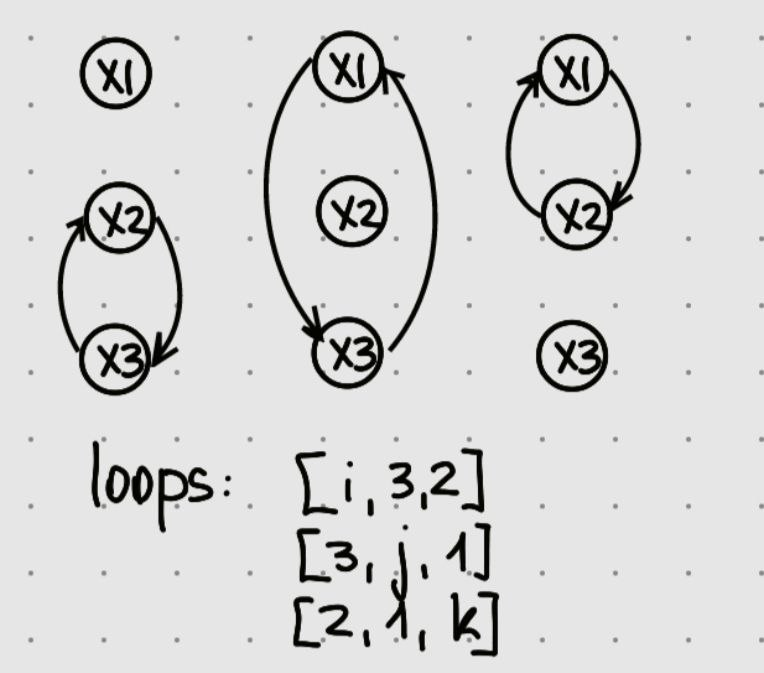

**c)** Find the best model which has the highest posterior probability. Use a model prior $p(G)$ that is uniform over all possible models. Does the best model have some regulatory interactions between the genes, i.e. links in the DAG that defines the Bayesian network structure?

In [68]:
N = 16*4-12
N_opt = 18
score = [0]*N_opt
G_opt = []
G = [0]*N
idx = 0
for i in range(4):
    for j in range(4):
        for k in range(4):
            # do not consider graphs with loops
            if (j == 3 and k == 2) or (i == 3 and k == 1) or (i == 2 and j == 1):
                continue
            else:
                G[idx] = [i, j, k]
                # do not consider graphs with self-loops
                if G[idx][0] == 1 or G[idx][1] == 2 or G[idx][2] == 3:
                    continue
                else:
                    # prior probability as uniform over all models ln 𝑝(𝐺) = ln (1/18)
                    score[idx] = log_marginal_likelihood(Y_disc, G[idx])+np.log(1/N_opt)
                    G_opt.append(G[idx])
                    idx +=1
pairs = zip(score, G_opt)
sort_pairs = sorted(list(pairs), key=lambda tup: tup[0])
print(sort_pairs)

[(-49.15319675458274, [0, 0, 2]), (-49.15319675458274, [0, 3, 0]), (-48.79498717039796, [0, 1, 2]), (-48.79498717039796, [2, 0, 2]), (-48.79498717039796, [2, 3, 0]), (-45.850548191231525, [0, 3, 1]), (-45.850548191231525, [3, 0, 2]), (-45.850548191231525, [3, 3, 0]), (-45.49233860704675, [2, 3, 1]), (-45.49233860704675, [3, 1, 2]), (-44.26438226660703, [0, 0, 0]), (-43.90617268242225, [0, 1, 0]), (-43.90617268242225, [2, 0, 0]), (-40.96173370325581, [0, 0, 1]), (-40.96173370325581, [3, 0, 0]), (-40.60352411907103, [0, 1, 1]), (-40.60352411907103, [2, 0, 1]), (-40.60352411907103, [3, 1, 0])]


As can be seen, the best model with score -40.603 has interactions between nodes (genes) and it can be represented by several graphs G: [0, 1, 1], [2, 0, 1], [3, 1, 0]


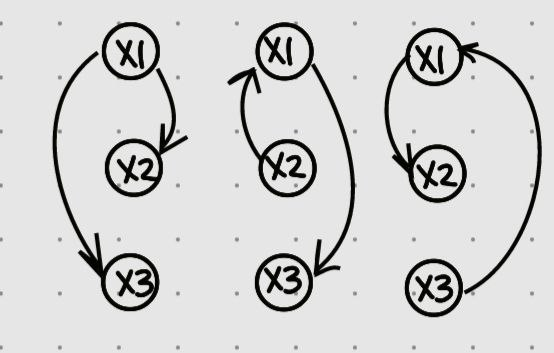

**Note:** You will see that in one-link models, you cannot distinguish between direction of the arrow, and in two-link models you cannot make distinction between `X <- Y <- Z`, `X -> Y -> Z` and `X <- Y -> Z`. You can still consider these as different models.